# ISS PROJEKT 2022
### Author: Safar Radim xsafar27 242070

# 1. Nacteni (ukradnuto ze zadani)

In [ ]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import scipy.signal as ss
import os

MIDIFROM = 24
MIDITO = 108
SKIP_SEC = 0.25
HOWMUCH_SEC = 0.5
WHOLETONE_SEC = 2

howmanytones = MIDITO - MIDIFROM + 1
tones = np.arange(MIDIFROM, MIDITO + 1)
s, Fs = sf.read('klavir.wav')
N = int(Fs + HOWMUCH_SEC)
Nwholetone = int(Fs * WHOLETONE_SEC)
xall = np.zeros((MIDITO + 1, N))
samplefrom = int(SKIP_SEC * Fs)
sampleto = samplefrom + N

for tone in tones:
    x = s[samplefrom:sampleto]
    x = x - np.mean(x)
    xall[tone,:] = x
    samplefrom += Nwholetone
    sampleto += Nwholetone

# Ukoly
## 1. Ukol
Je dost mozne ze mam zapis do souboru moc overengineered. Ale jistota je jistota.  
log(0) resim tak, ze tisku az od prvni hodnoty, nemam tak v grafu tu hnusou caru dolu.  

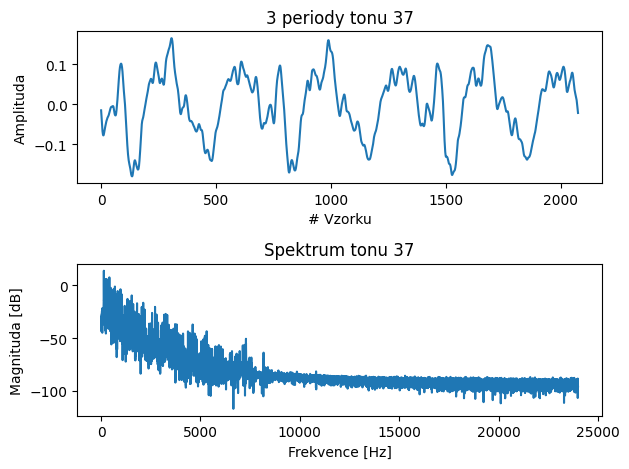

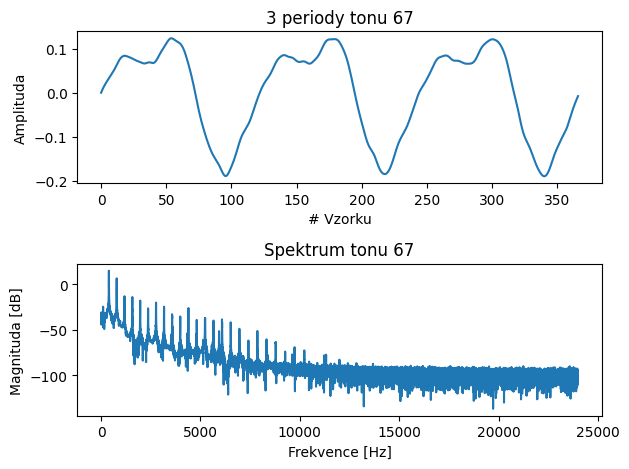

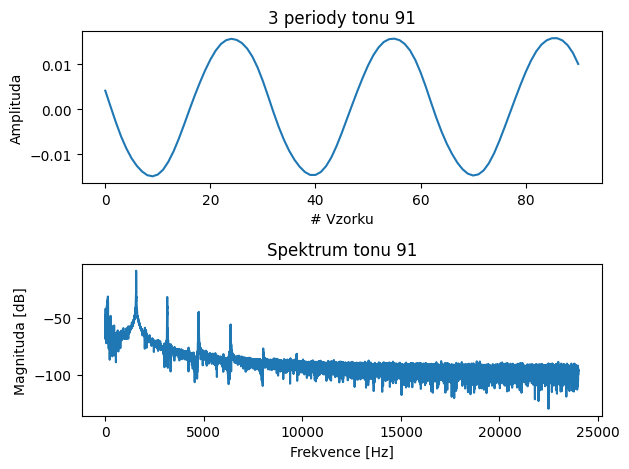

In [968]:
# Tony na zpracovani
my_tones = [(37, 69.30, "a"), (67, 392.00, "b"), (91, 1567.98, "c")]
basedir = os.path.abspath("./audio")
for pair in my_tones:
    tone = xall[pair[0]]
    path = os.path.join(basedir, "{}_orig.wav".format(pair[2]))
    sf.write(path, tone, Fs)
    amount = int (Fs * 3 / pair[1])

    # Oddeleni grafu
    fig = plt.figure(pair[0])

    # Plotnuti samotneho tonu
    tone_plt = fig.add_subplot(211)
    tone_plt.plot(tone[:amount])
    tone_plt.set_title("3 periody tonu {}".format(pair[0]))
    tone_plt.set_xlabel("# Vzorku")
    tone_plt.set_ylabel("Amplituda")

    # Plotnuti spektra
    spectrum_plt = fig.add_subplot(212)
    tone_dft = np.fft.fft(tone)
    G = 10 * np.log10( 1 / tone.size * np.abs(tone_dft)**2)
    freg = np.arange(G.size) * Fs / tone.size
    spectrum_plt.plot(freg[1:freg.size//2], G[1:freg.size//2])
    spectrum_plt.set_title("Spektrum tonu {}".format(pair[0]))
    spectrum_plt.set_xlabel("Frekvence [Hz]")
    spectrum_plt.set_ylabel("Magnituda [dB]")

    # At vidime popisky
    fig.tight_layout()


## 2. Ukol
Prvnich 24 indexu nejsou tony, takze vratim None a jdu dale.  
Az do indexu 60 pouzivam autokorelaci ze scipy (cerpano z dokumentace).   
FFT me fungovalo jak melo, tj. nenechazelo to 2x nebo i 3x vyssi frekvence, az pri vyssich hodnotach.  

In [982]:
def find_base_freq(tone, index, plot=0):
    if index < 24:
        return None

    if index < 60:
        tone_half = tone[ : tone.size]
        correlation = ss.correlate(tone, tone)
        # +50 je muj "prah"
        correlation = correlation[(correlation.size// 2) + 50:]
        # -20 je magicka konstanta na orezani jen realnych peaku
        peaks, _ = ss.find_peaks(correlation, height=correlation.max() - 20)

        if plot == 1:
            figure = plt.figure(index)
            figure = figure.add_subplot(111)
            figure.plot(correlation)
            figure.axvline(x=peaks[0], color = 'r')
            plt.xlim(left = -10, right=10000)
            figure.set_title("Autokorelace tonu {}".format(index))
            figure.set_xlabel("Vzorek")
            figure.set_ylabel("Koeficient")

        coef = peaks[1] - peaks[0]
        peaks = Fs / coef

    else:
        tone_dft = np.fft.rfft(tone)
        module = np.abs(tone_dft)
        peaks, _ = ss.find_peaks(module, height=module.max() - 1)

        if plot == 1:
            G = 10 * np.log10( 1 / tone.size * np.abs(tone_dft)**2)
            freg = np.arange(G.size) * Fs / tone.size
            figure = plt.figure(index)
            figure = figure.add_subplot(111)
            figure.plot(freg[1:freg.size//2], G[1:freg.size//2])
            figure.axvline(x=peaks[0], color = 'r')
            plt.xlim(left = -10, right=10000)
            figure.set_title("Spektrum tonu {}".format(index))
            figure.set_xlabel("Frekvence [Hz]")
            figure.set_ylabel("Magnituda [dB]")
            
    return peaks


Generace hodnot f0 pro vsechny tony.

In [ ]:
# Vsechny tony a jejich freq
# Duvod pro nepresnosti frekvenci muzou byt "neidealnost" klaviru
# Tj. klavir nebyl naladeny na presnost, jakou muzeme ziskat z pocitace
for index, tone in enumerate(xall):
    base_freq = find_base_freq(tone, index)
    if base_freq is None:
        continue
    print("Pro ton {} je peak {}".format(index, np.round(base_freq, decimals=2)))


A nasledne generovani grafu pro moje 3 tony, autokorelace byla pouzita jen u prvniho.

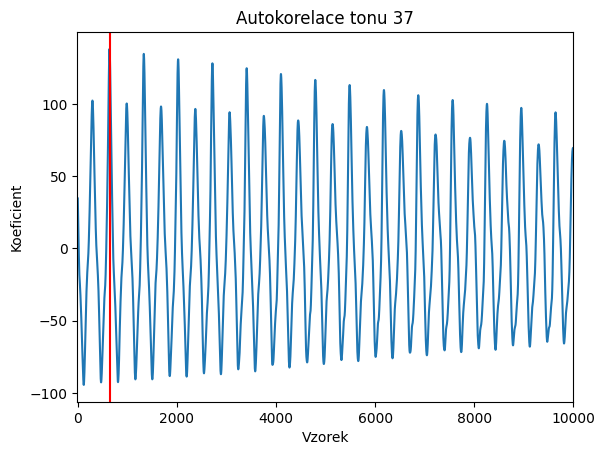

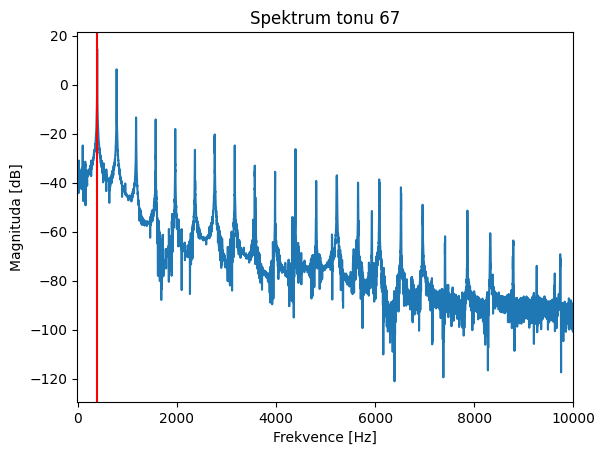

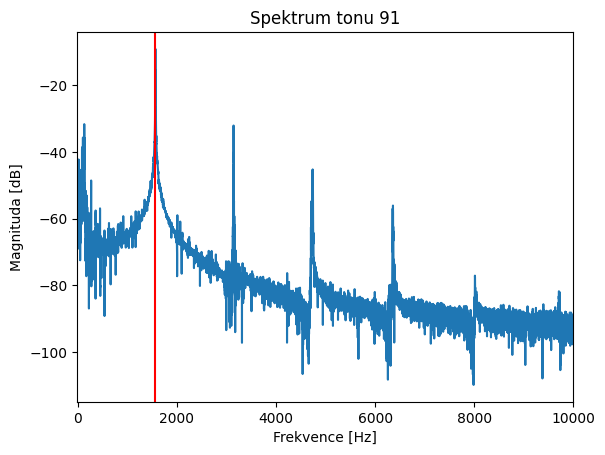

In [983]:
for tone in my_tones:
    index = tone[0]
    find_base_freq(xall[index], index, plot=1)

## 3. Ukol
DTFT ukradeno z 02_spectral.
Nejtezsi bylo asi desifrovani co znamena jaka promenna.
Magicka konstanta 1.029302237 je odvozena z podminky 50 centu, odvozeni lze videt nad pouzitim.

In [ ]:
def find_base_freq_dtft(tone, index):
    if index < 24:
        return None
    FREQPOINTS = 500

    n = np.arange(0, Fs)

    tone_fft = np.fft.fft(tone)
    kall = np.arange(0, Fs // 2)
    tone_mag = np.abs(tone_fft[kall])
    tone_phase = np.angle(tone_fft[kall])

    f = kall / Fs * Fs

    fmax = f[np.argmax(tone_mag)]
    tone_max = np.max(tone_mag)
    """
    1200 * log_2(f2/f1) = 50
    log 2(f2/f1) = 50/1200
    f2/f1 = 2^(5/120)
    f2 = 2^(5/120) * f1
    """
    FREQRANGE = (1.029302237 * fmax) - fmax

    ffrom = fmax - FREQRANGE
    fto = fmax + FREQRANGE

    fsweep = np.linspace(ffrom, fto, FREQPOINTS)

    A = np.zeros([FREQPOINTS, N], dtype=complex)
    for k in np.arange(0, FREQPOINTS):
        A[k, :] = np.exp( -1j * 2 * np.pi * fsweep[k] / Fs * n)
    Xdtft = np.matmul(A, tone.T)
    precisefmax = fsweep[np.argmax(np.abs(Xdtft))]

    # koeficienty kde mam 2* zakladni
    if index <= 36 or 53 <= index <= 55:
        precisefmax = precisefmax / 2
    
    if 37 <= index <= 40:
        precisefmax = precisefmax / 3

    return (precisefmax, tone_mag, tone_phase)



DTFT zabere podstatne dele, ale opravdu je presnejsi.  
Oproti klasickemu FFT ma hlavne i desetiny, pro lepsi zobrazeni zaokrouhluji vystup na dve.  

In [ ]:
for index, tone in enumerate(xall):
    dtft_base = find_base_freq_dtft(tone, index)
    base = find_base_freq(tone, index)
    if dtft_base is None:
        continue
    
    print("DTFT: Pro ton {} je peak {}".format(index, np.round(dtft_base[0], decimals=2)))

## 4. Ukol
Vybral jsem moznost 5 magnitud a 5 fazi.  
U vyssich frekvenci bych s deseti magnitudami narazel na moc velke frekvence.  

In [ ]:
def get_floats(tones):
    float_tones = np.zeros((MIDITO + 1, 10))
    freq_tones = np.zeros(MIDITO + 1)

    for index, tone in enumerate(tones):
        ret_val = find_base_freq_dtft(tone, index)
        tone_arr = np.zeros(10)

        if ret_val is None:
            float_tones[index, :] = tone_arr
            continue

        for i in range(0, 5):
            freq_index = int(ret_val[0]) * (i + 1)
            tone_arr[2 * i] = ret_val[1][freq_index]
            tone_arr[2 * i + 1] = ret_val[2][freq_index]
        
        float_tones[index, :] = tone_arr
        freq_tones[index] = ret_val[0]

    return (float_tones, freq_tones)


Fce abych si to mohl ukazat.  
Cast `G[int(baseFreq[index]) * (i + 1)]` me zabrala az moc dlouho.

In [990]:
def floats_graph(in_tone, floats, baseFreq):
    index = in_tone[0]
    tone = xall[in_tone[0]]
    tone_dft = np.fft.fft(tone)
    G = 10 * np.log10( 1 / tone.size * np.abs(tone_dft)**2)
    freg = np.arange(G.size) * Fs / tone.size

    figure = plt.figure(index)
    figure = figure.add_subplot(111)
    figure.plot(freg[1:freg.size//2], G[1:freg.size//2])
    plt.xlim(0, int(baseFreq[index]) * 11)
    plt.autoscale(True, 'y')
    figure.set_title("Spektrum tonu {} s vyznamnymi frekvencemi".format(index))
    figure.set_xlabel("Frekvence [Hz]")
    figure.set_ylabel("Magnituda [dB]")

    for i in range(5):
        figure.plot(baseFreq[index] * (i + 1), G[int(baseFreq[index]) * (i + 1)], ".", markersize=10)
    

Zneuziju vlastnost .ipynb a tak si to cele spocitam jen jednou.  
Nemusim pote tohoto zrouta casu poustet opakovane.  

In [ ]:
ret_arr = get_floats(xall)
float_arr = ret_arr[0]
freq_arr = ret_arr[1]

Absolutne nevim proc mam ty body mimo jasne viditelne peaky.  
Moje domenka je nepresny vypocet ci nepresnost samotneho signalu.

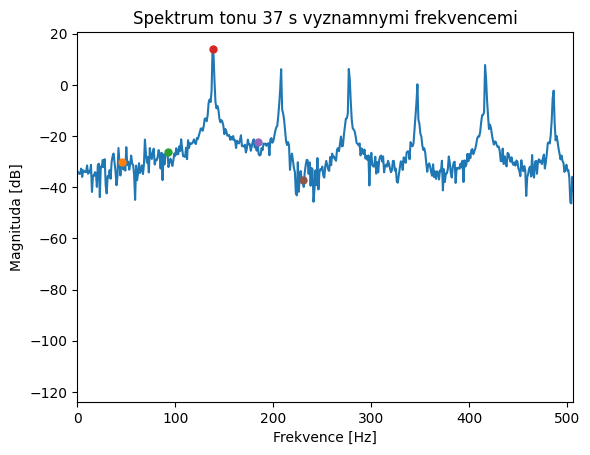

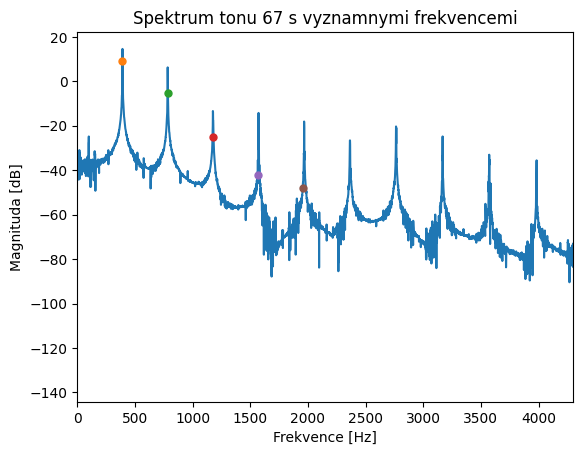

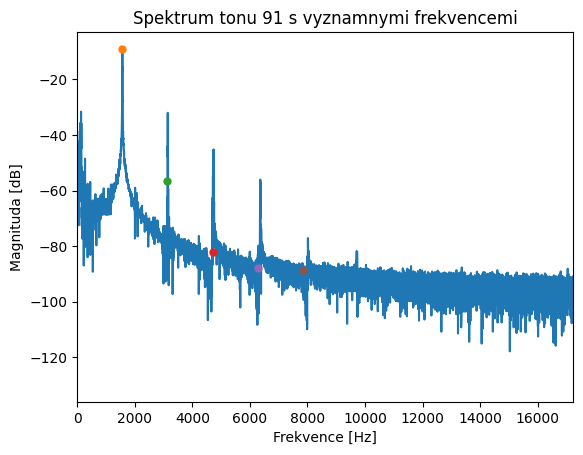

In [991]:
for tone in my_tones:
    floats_graph(tone, float_arr, freq_arr)

## 5. Ukol
Snad i snaha se ceni, ale nekde mam tak hluboko zakopaneho psa ze mi to hlava nebere.  
Bud neumim psat python a nebo je nekde chyba.  

/home/bread/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


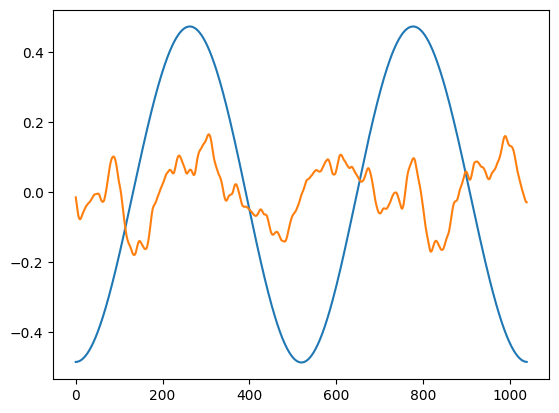

In [992]:
index = 37
amount = int (Fs * 1 / freq_arr[index])

mod = np.zeros(5)
pha = np.zeros(5)

for i in range(5):
    mod[i] = float_arr[index][2 * i]
    pha[i] = float_arr[index][2 * i + 1]

x = np.cos(pha)* mod
pls_work = np.fft.ifft(x, amount)

plt.plot(pls_work)
plt.plot(xall[index][:amount])